In [20]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import time
import pickle
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer

from multioutput_functions import *

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

In [22]:
def f1score_jd(true_Y,pred_Y):
    f1_score=[]
    weights=[]
    totlength = len(true_Y)

    for value in [0,1]:
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        match_value = np.where(np.array(true_Y) == pred_Y)[0]
        postn_value = np.where(true_Y ==  value)[0]
        weights.append(len(postn_value)/totlength)
        for i in postn_value:
            if i in match_value:
                tp +=1
            elif i not in match_value:
                fn +=1
        for i in match_value:
            if i not in postn_value:
                tn +=1
        fp = len(true_Y)-tn-fn-tp

        if tp==0:
            precision = 0
            recall = 0
            f1_score = 0
        else:
            precision = tp/(fp+tp)
            recall    = tp/(fn+tp)
            f1_score.append(2*precision*recall/(precision + recall))
    
    f1_weighted = np.array(f1_score)*np.array(weights)

    # return np.nanmean(f1_score)
    return np.nansum(f1_weighted)

In [23]:
def RF_optimize(DF_,wave,telluric=False,optimization=False,jobs=-1,Group=''):

    Bardalez = ['G1','Bardalez']
    Burgasser = ['G2','Burgasser']
    alltypes = ['G3','all','']
    earlytypes = ['G4','late']
    if Group in Bardalez:
        typerange=[[16,27],[31,38]]
    elif Group in Burgasser:
        typerange=[[25,32],[32,38]]
    elif Group in alltypes:
        typerange=[[16,39],[16,39]]
    elif Group in earlytypes:
        typerange=[[16,30],[16,32]]
    elif (type(Group)==list):
        if len(Group)==2:
            if (len(Group[0])==2)&(len(Group[1])==2):
                typerange=Group
    else:
        return print('Error. Select a valid group')
    
    
    sins=DF_[DF_.num_class==0]
    bins=DF_[DF_.num_class==1]
    
    if 'primary_type' in DF_.columns:
        bins = bins[bins.primary_type>=typerange[0][0]]
        bins = bins[bins.primary_type<=typerange[0][1]]
        bins = bins[bins.secondary_type>=typerange[1][0]]
        bins = bins[bins.secondary_type<=typerange[1][1]]
    else:
        return print('Include a column with the primary and secondary types for the binaries')

    if 'system_interpolated_flux' in DF_.columns:
        fluxcolname = 'system_interpolated_flux'
    elif 'FLUX' in DF_.columns:
        fluxcolname = 'FLUX'
    else: return print('Missing flux column')
    if 'system_interpolated_noise' in DF_.columns:
        noisecolname = 'system_interpolated_noise'
    elif 'UNCERTAINTY' in DF_.columns:
        noisecolname = 'UNCERTAINTY'
    else: return print('Missing noise column')

    bin_types=[]
    for flux_i,noise_i in zip(bins[fluxcolname],bins[noisecolname]):
        bin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))

    sin_types=[]
    for flux_i,noise_i in zip(sins[fluxcolname],sins[noisecolname]):
        sin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))
    sin_types = np.array(sin_types)
    sins = sins[(sin_types>=min(bin_types)) & (sin_types<=max(bin_types))]
    
    DF_ = pd.concat([sins,bins.drop(['primary_type','secondary_type'],axis=1)],axis=0)


    RSEED = 42  

    feats = ['flux_' + str(k) for k in range(409)]

    
    X0 = np.array(DF_[feats]) #data
    y0 = np.array(DF_['num_class']) #labels 

    X_train, X_test, y_train, y_test = train_test_split(X0,y0,train_size=0.7, random_state=RSEED, shuffle=True)
    if telluric:
        tm = np.logical_or(np.logical_and(wave > 1.35,wave < 1.42), np.logical_and(wave > 1.8,wave < 1.95))
        X_train = np.array([X_train[i][~tm] for i in range(len(X_train))])
        X_test = np.array([X_test[i][~tm] for i in range(len(X_test))])
    data_test = {'X_test':X_test,
                'y_test':y_test}

    param_grid = dict(n_estimators=[int(i) for i in np.linspace(1,151,76)],max_depth=[15,25,None])
    # param_grid = dict(n_estimators=[int(i) for i in np.linspace(2,40,20)],max_depth=[15,25,None])
    custom_scorer = make_scorer(f1score_jd, greater_is_better=True)
    RF = RandomForestClassifier()
    grid_search = RandomizedSearchCV(RF, param_grid, n_jobs=-1, n_iter=10, scoring=custom_scorer)
    # grid_search = RandomizedSearchCV(RF, param_grid, n_jobs=-1, n_iter=7, scoring=custom_scorer)

    grid_search.fit(X_train, y_train)
    return grid_search, data_test

In [24]:
with open('data/SinDF_hig.pickle', 'rb') as f:
        SinDF_hig=pickle.load(f)
with open('data/BinDF_hig.pickle', 'rb') as f:
        BinDF_hig = pickle.load(f)
# BinDF_hig.drop(['primary_type','secondary_type'],axis=1,inplace=True)

num_class=[]
for i in range(len(BinDF_hig)):
    num_class.append(1)
BinDF_hig["num_class"]=num_class

num_class=[]
for i in range(len(SinDF_hig)):
    num_class.append(0)
SinDF_hig["num_class"]=num_class

DF_hig = pd.concat([SinDF_hig,BinDF_hig],axis=0)

In [25]:
wave = DF_hig['WAVE'].iloc[0]

In [26]:
start = time.time()
grid_hig_G1, data_hig_G1 = RF_optimize(DF_hig, wave, Group='G1')
RF_hig_G1 = grid_hig_G1.best_estimator_
X_hig_G1 = data_hig_G1['X_test']
y_hig_G1 = data_hig_G1['y_test']
z_hig_G1 = RF_hig_G1.predict(X_hig_G1)
end = time.time()
print(end-start)

328.8579308986664


In [27]:
grid_hig_G1.cv_results_

{'mean_fit_time': array([146.37387233, 128.32233362,  21.55271859,  57.13193507,
          5.28551083,  70.63047628,   7.44699278,  38.51787386,
         53.04096775,  67.07112379]),
 'std_fit_time': array([0.42535076, 1.17905509, 0.42354192, 0.87275148, 0.49202605,
        0.5827529 , 0.35476161, 0.37979607, 3.46820707, 0.7897955 ]),
 'mean_score_time': array([0.97635016, 0.84900103, 0.45106368, 0.59360094, 0.39091697,
        0.67400665, 0.40691471, 0.44851494, 0.38000112, 0.29262142]),
 'std_score_time': array([0.02398554, 0.05033272, 0.00849352, 0.02394166, 0.01021383,
        0.08156976, 0.0185884 , 0.04884218, 0.03914146, 0.03078592]),
 'param_n_estimators': masked_array(data=[145, 127, 21, 57, 5, 69, 7, 39, 69, 113],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[25, None, 25, 25, 15, None, None, 25, 15, 15],
              mas

In [28]:
grid_hig_G1.cv_results_['mean_test_score']

array([0.97212323, 0.97234967, 0.96923017, 0.97151267, 0.94562801,
       0.97186733, 0.96048509, 0.97124775, 0.95586717, 0.95566152])

In [29]:
f1score_jd(y_hig_G1,z_hig_G1)

0.9747391219417263

The raw features produce a model with precision ~0.9987
{'0': {'precision': 0.9704290429042904, 'recall': 0.9997280021759826, 'f1-score': 0.9848606645230439, 'support': 14706}, '1': {'precision': 0.9987468671679198, 'recall': 0.8767876787678768, 'f1-score': 0.9338019917984768, 'support': 3636}, 'accuracy': 0.9753571039145131, 'macro avg': {'precision': 0.9845879550361052, 'recall': 0.9382578404719297, 'f1-score': 0.9593313281607603, 'support': 18342}, 'weighted avg': {'precision': 0.9760425860851081, 'recall': 0.9753571039145131, 'f1-score': 0.9747391219417264, 'support': 18342}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

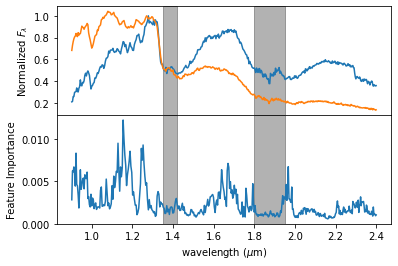

In [30]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G1, z_hig_G1)))
class_report_hig_G1 = classification_report(y_hig_G1,z_hig_G1, digits=4, output_dict=True)
print(class_report_hig_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave),list(SinDF_hig.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_hig.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_hig_G1.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9987
{'0': {'precision': 0.9704290429042904, 'recall': 0.9997280021759826, 'f1-score': 0.9848606645230439, 'support': 14706}, '1': {'precision': 0.9987468671679198, 'recall': 0.8767876787678768, 'f1-score': 0.9338019917984768, 'support': 3636}, 'accuracy': 0.9753571039145131, 'macro avg': {'precision': 0.9845879550361052, 'recall': 0.9382578404719297, 'f1-score': 0.9593313281607603, 'support': 18342}, 'weighted avg': {'precision': 0.9760425860851081, 'recall': 0.9753571039145131, 'f1-score': 0.9747391219417264, 'support': 18342}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

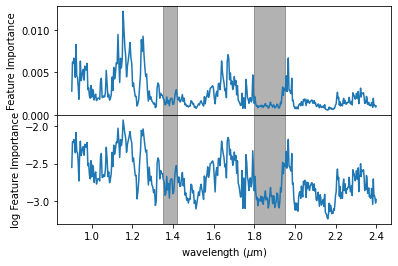

In [31]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G1, z_hig_G1)))
class_report_hig_G1 = classification_report(y_hig_G1,z_hig_G1, digits=4, output_dict=True)
print(class_report_hig_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave), list(RF_hig_G1.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_hig_G1.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [32]:
start = time.time()
grid_hig_G2, data_hig_G2 = RF_optimize(DF_hig, wave, Group='G2')
RF_hig_G2 = grid_hig_G2.best_estimator_
X_hig_G2 = data_hig_G2['X_test']
y_hig_G2 = data_hig_G2['y_test']
z_hig_G2 = RF_hig_G2.predict(X_hig_G2)
end = time.time()
print(end-start)

141.356294631958


In [33]:
grid_hig_G2.cv_results_

{'mean_fit_time': array([45.22302656, 12.7472208 , 11.88172684, 28.67513666,  2.42644734,
        28.56166434, 37.90112882, 38.87699084, 13.88593545,  7.37068367]),
 'std_fit_time': array([0.46676473, 0.14199884, 0.08806434, 0.21296738, 0.11460026,
        0.3119648 , 2.65965892, 0.59878867, 0.13833109, 0.48194851]),
 'mean_score_time': array([0.35840602, 0.25920181, 0.24732604, 0.30977941, 0.2165091 ,
        0.31401262, 0.22305093, 0.1550139 , 0.24693241, 0.18674126]),
 'std_score_time': array([0.00932248, 0.00815529, 0.00700092, 0.01808609, 0.00835167,
        0.00569937, 0.05725766, 0.01723647, 0.00361918, 0.02320026]),
 'param_n_estimators': masked_array(data=[97, 27, 25, 61, 5, 61, 91, 111, 29, 17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[15, None, 25, 15, None, 25, 25, None, 15, None],
              mask=[False, False, 

In [34]:
f1score_jd(y_hig_G2,z_hig_G2)

0.9981657884775536

The raw features produce a model with precision ~1.0000
{'0': {'precision': 0.9978403755868545, 'recall': 1.0, 'f1-score': 0.9989190205386097, 'support': 10627}, '1': {'precision': 1.0, 'recall': 0.9881626351003603, 'f1-score': 0.9940460781775822, 'support': 1943}, 'accuracy': 0.9981702466189339, 'macro avg': {'precision': 0.9989201877934273, 'recall': 0.9940813175501801, 'f1-score': 0.996482549358096, 'support': 12570}, 'weighted avg': {'precision': 0.9981741981990058, 'recall': 0.9981702466189339, 'f1-score': 0.9981657884775536, 'support': 12570}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

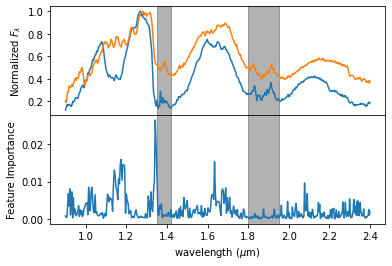

In [35]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G2, z_hig_G2)))
class_report_hig_G2 = classification_report(y_hig_G2,z_hig_G2, digits=4, output_dict=True)
print(class_report_hig_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave),list(SinDF_hig.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_hig.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_hig_G2.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~1.0000
{'0': {'precision': 0.9978403755868545, 'recall': 1.0, 'f1-score': 0.9989190205386097, 'support': 10627}, '1': {'precision': 1.0, 'recall': 0.9881626351003603, 'f1-score': 0.9940460781775822, 'support': 1943}, 'accuracy': 0.9981702466189339, 'macro avg': {'precision': 0.9989201877934273, 'recall': 0.9940813175501801, 'f1-score': 0.996482549358096, 'support': 12570}, 'weighted avg': {'precision': 0.9981741981990058, 'recall': 0.9981702466189339, 'f1-score': 0.9981657884775536, 'support': 12570}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

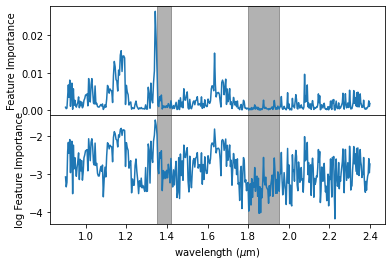

In [36]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G2, z_hig_G2)))
class_report_hig_G2 = classification_report(y_hig_G2,z_hig_G2, digits=4, output_dict=True)
print(class_report_hig_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave), list(RF_hig_G2.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_hig_G2.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [37]:
start = time.time()
grid_hig_G3, data_hig_G3 = RF_optimize(DF_hig, wave, Group='G3')
RF_hig_G3 = grid_hig_G3.best_estimator_
X_hig_G3 = data_hig_G3['X_test']
y_hig_G3 = data_hig_G3['y_test']
z_hig_G3 = RF_hig_G3.predict(X_hig_G3)
end = time.time()
print(end-start)

825.920330286026


In [38]:
grid_hig_G3.cv_results_

{'mean_fit_time': array([194.40317135, 204.00832486, 293.44421787, 134.96003819,
         73.86689725,   2.66572623, 216.45733814, 308.46279979,
        252.3424943 ,  43.21921802]),
 'std_fit_time': array([1.48103252, 2.31252734, 2.79254007, 2.38687971, 0.67505671,
        0.09734101, 2.65236537, 4.34935056, 6.92762832, 1.00544485]),
 'mean_score_time': array([1.55104866, 1.55621219, 1.89846067, 1.29211216, 1.11198487,
        0.79537287, 1.54112878, 0.82466583, 1.09725542, 0.9978776 ]),
 'std_score_time': array([0.0508451 , 0.02871872, 0.06522221, 0.04151429, 0.03471867,
        0.01910801, 0.04750519, 0.098925  , 0.12989404, 0.08376818]),
 'param_n_estimators': masked_array(data=[99, 103, 125, 67, 31, 1, 89, 151, 139, 21],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[15, 15, 25, 15, 25, 25, None, None, 15, 15],
              mas

In [39]:
f1score_jd(y_hig_G3,z_hig_G3)

0.9676249630365431

The raw features produce a model with precision ~0.9796
{'0': {'precision': 0.9596528795221458, 'recall': 0.9857605927297985, 'f1-score': 0.9725315515961396, 'support': 17276}, '1': {'precision': 0.9795901435327304, 'recall': 0.9428252016290026, 'f1-score': 0.9608561197916667, 'support': 12523}, 'accuracy': 0.9677170374844793, 'macro avg': {'precision': 0.9696215115274381, 'recall': 0.9642928971794006, 'f1-score': 0.9666938356939032, 'support': 29799}, 'weighted avg': {'precision': 0.968031494818114, 'recall': 0.9677170374844793, 'f1-score': 0.9676249630365431, 'support': 29799}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

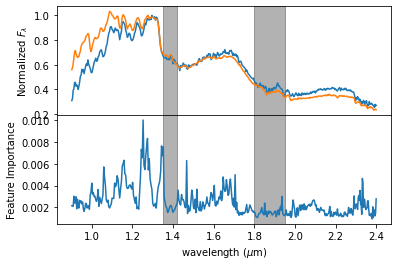

In [40]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G3, z_hig_G3)))
class_report_hig_G3 = classification_report(y_hig_G3,z_hig_G3, digits=4, output_dict=True)
print(class_report_hig_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave),list(SinDF_hig.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_hig.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_hig_G3.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9796
{'0': {'precision': 0.9596528795221458, 'recall': 0.9857605927297985, 'f1-score': 0.9725315515961396, 'support': 17276}, '1': {'precision': 0.9795901435327304, 'recall': 0.9428252016290026, 'f1-score': 0.9608561197916667, 'support': 12523}, 'accuracy': 0.9677170374844793, 'macro avg': {'precision': 0.9696215115274381, 'recall': 0.9642928971794006, 'f1-score': 0.9666938356939032, 'support': 29799}, 'weighted avg': {'precision': 0.968031494818114, 'recall': 0.9677170374844793, 'f1-score': 0.9676249630365431, 'support': 29799}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

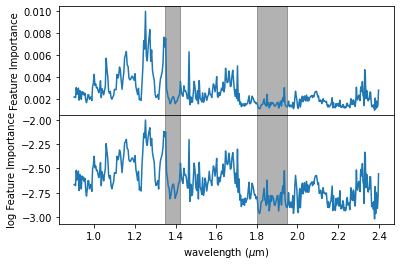

In [41]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G3, z_hig_G3)))
class_report_hig_G3 = classification_report(y_hig_G3,z_hig_G3, digits=4, output_dict=True)
print(class_report_hig_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave), list(RF_hig_G3.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_hig_G3.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [42]:
start = time.time()
grid_hig_G4, data_hig_G4 = RF_optimize(DF_hig, wave, Group='G4')
RF_hig_G4 = grid_hig_G4.best_estimator_
X_hig_G4 = data_hig_G4['X_test']
y_hig_G4 = data_hig_G4['y_test']
z_hig_G4 = RF_hig_G4.predict(X_hig_G4)
end = time.time()
print(end-start)

539.4647121429443


In [43]:
grid_hig_G4.cv_results_

{'mean_fit_time': array([ 15.27032371,  43.71196332, 154.80770216,  93.6926475 ,
        221.51058974,  37.93623319, 206.91530824, 174.09724417,
        128.54197874,   1.86819754]),
 'std_fit_time': array([ 0.47871605,  1.04037738,  0.7049022 ,  1.37559616,  1.29601096,
         0.22973361,  5.1300299 ,  1.26542396, 21.40082465,  0.05181873]),
 'mean_score_time': array([0.55885038, 0.67726536, 1.08016806, 0.84348969, 1.30920987,
        0.64999461, 0.8605794 , 0.83548555, 0.51836219, 0.49374123]),
 'std_score_time': array([0.00684913, 0.01908857, 0.02303383, 0.01990717, 0.02197333,
        0.00537624, 0.22279355, 0.09667878, 0.17820078, 0.00610629]),
 'param_n_estimators': masked_array(data=[9, 27, 97, 57, 137, 27, 131, 125, 121, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[None, 25, 25, None, 25, 15, 25, 15, 15, None],
      

In [44]:
f1score_jd(y_hig_G4,z_hig_G4)

0.9548024372823425

In [46]:
RF_hig_G4

RandomForestClassifier(max_depth=25, n_estimators=137)

The raw features produce a model with precision ~0.9701
{'0': {'precision': 0.9457664233576643, 'recall': 0.9809963658388855, 'f1-score': 0.9630593132154006, 'support': 13208}, '1': {'precision': 0.9701332698714897, 'recall': 0.9164793165467626, 'f1-score': 0.9425433526011561, 'support': 8896}, 'accuracy': 0.9550307636626855, 'macro avg': {'precision': 0.957949846614577, 'recall': 0.948737841192824, 'f1-score': 0.9528013329082783, 'support': 22104}, 'weighted avg': {'precision': 0.9555731310389431, 'recall': 0.9550307636626855, 'f1-score': 0.9548024372823424, 'support': 22104}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

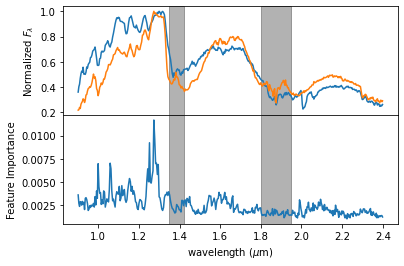

In [47]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G4, z_hig_G4)))
class_report_hig_G4 = classification_report(y_hig_G4,z_hig_G4, digits=4, output_dict=True)
print(class_report_hig_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave),list(SinDF_hig.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_hig.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_hig_G4.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9701
{'0': {'precision': 0.9457664233576643, 'recall': 0.9809963658388855, 'f1-score': 0.9630593132154006, 'support': 13208}, '1': {'precision': 0.9701332698714897, 'recall': 0.9164793165467626, 'f1-score': 0.9425433526011561, 'support': 8896}, 'accuracy': 0.9550307636626855, 'macro avg': {'precision': 0.957949846614577, 'recall': 0.948737841192824, 'f1-score': 0.9528013329082783, 'support': 22104}, 'weighted avg': {'precision': 0.9555731310389431, 'recall': 0.9550307636626855, 'f1-score': 0.9548024372823424, 'support': 22104}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

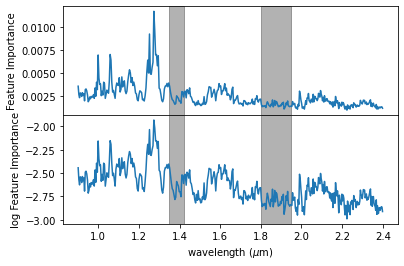

In [48]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_hig_G4, z_hig_G4)))
class_report_hig_G4 = classification_report(y_hig_G4,z_hig_G4, digits=4, output_dict=True)
print(class_report_hig_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_hig))
Bin_i = random.randint(0,len(BinDF_hig))
ax[0].plot(list(wave), list(RF_hig_G4.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_hig_G4.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')